In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score

Step 0: load our data

In [3]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/metadata/fully_concatenated_data.csv", lineterminator='\n')

In [4]:
# List of image and text feature columns to keep
image_columns = [f'image_{i}' for i in range(0, 2049)]
text_columns = [f'text_{i}' for i in range(0, 768)]

# Additional columns you want to keep
additional_columns_to_keep = ['like_count', 'comment_count', 'post_id', 'Followers', 'Username', 'Is_English', 'Image_Count']

# Combine both lists of columns to keep
columns_to_keep = image_columns + additional_columns_to_keep + text_columns

# Drop all columns except those specified in columns_to_keep
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

# Drop the unwanted columns from the dataframe
data_2 = data.drop(columns=columns_to_drop)


# Maybe don't delete category and detected languages
# Same with comments disabled and video
# potential columns to add or not:
#'comments_disabled',
#'is_video'
# Category
data_2.head(10)

# Filter image count to 10 or less, which is what is realistic in the industry
data_2 = data_2[data_2['Image_Count'] <= 1]

In [5]:
# Filter the DataFrame to keep only observations where 'Is_English' is True
data_2 = data_2[data_2['Is_English'] == True]

Step 1: group and split the data by post_id

Define a popularity variable

In [6]:
# Set the engagement rate variable
data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))

<ipython-input-6-747e2ff0d805>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))


Let's split the data!

In [7]:
# Define the number of iterations and an array to store accuracies
n_iterations = 7
accuracies = []

for seed in range(n_iterations):
    print(f"Iteration {seed+1}")

    # Split users into training and temporary sets with a new seed each time
    train_users, temp_users = train_test_split(data_2['Username'].unique(), test_size=0.2, random_state=seed)
    val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=seed)

    # Assign posts to training, validation, and test sets
    train_data = data_2[data_2['Username'].isin(train_users)]
    val_data = data_2[data_2['Username'].isin(val_users)]
    test_data = data_2[data_2['Username'].isin(test_users)]

    # Calculate the median popularity rate for each dataset
    median_popularity_rate_train = train_data['popularity'].quantile(0.5)
    train_data.loc[:, 'popularity'] = (train_data['popularity'] > median_popularity_rate_train).astype(int)
    median_popularity_rate_val = val_data['popularity'].quantile(0.5)
    val_data.loc[:, 'popularity'] = (val_data['popularity'] > median_popularity_rate_val).astype(int)
    median_popularity_rate_test = test_data['popularity'].quantile(0.5)
    test_data.loc[:, 'popularity'] = (test_data['popularity'] > median_popularity_rate_test).astype(int)

    # Prepare data for XGBoost
    X_train = train_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_train = train_data['popularity']
    X_val = val_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_val = val_data['popularity']
    X_test = test_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_test = test_data['popularity']

    # Convert datasets to LightGBM dataset format
    train_data_lgb = lgb.Dataset(X_train, label=y_train)
    val_data_lgb = lgb.Dataset(X_val, label=y_val)
    test_data_lgb = lgb.Dataset(X_test, label=y_test)

    # Define XGBoost model parameters
    params = {
        'objective': 'binary',
        'metric': 'binary_error',
        'alpha': 0.9,
        'learning_rate': 0.1
    }

    # Train the model
    # Train the LightGBM model
    bst = lgb.train(params,
                  train_data_lgb,
                  valid_sets=[train_data_lgb, val_data_lgb, test_data_lgb],
                  callbacks = [lgb.early_stopping(stopping_rounds=25)],
                  num_boost_round=1000)

    # Evaluate the model on the test set
    y_pred_prob = bst.predict(X_test)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for iteration {seed+1}: {accuracy:.2f}")

# Calculate the average accuracy across all iterations
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across {n_iterations} iterations: {average_accuracy:.2f}")

Iteration 1
[LightGBM] [Info] Number of positive: 45121, number of negative: 45122
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.446418 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 718080
[LightGBM] [Info] Number of data points in the train set: 90243, number of used features: 2816
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499994 -> initscore=-0.000022
[LightGBM] [Info] Start training from score -0.000022
Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:
[88]	training's binary_error: 0.306029	valid_1's binary_error: 0.403537	valid_2's binary_error: 0.401293
Accuracy for iteration 1: 0.60
Iteration 2
[LightGBM] [Info] Number of positive: 45409, number of negative: 45409
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.306804 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

In [8]:
# Alternatively, using numpy to generate bootstrap samples and calculate the percentiles
# Determine the size of the accuracies array
n = len(accuracies)
bootstrap_samples = np.random.choice(accuracies, (10000, n), replace=True)
ci_lower = np.percentile(bootstrap_samples, 2.5)
ci_upper = np.percentile(bootstrap_samples, 97.5)

print(f"Bootstrap 95% Confidence Interval: {ci_lower:.5f} - {ci_upper:.5f}")

Bootstrap 95% Confidence Interval: 0.59515 - 0.60514


[0.51513487 0.6062603  0.67930878 ... 0.49656353 0.53014184 0.54879669]


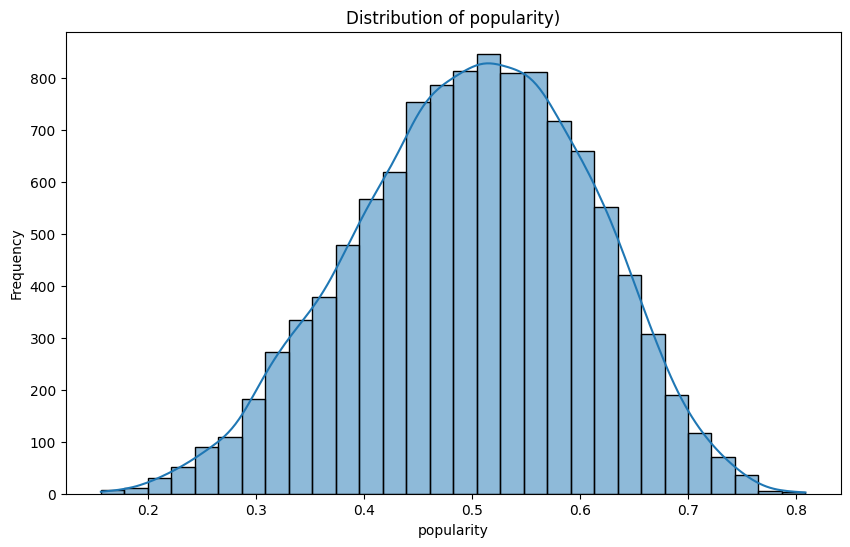

In [9]:
y_pred = bst.predict(X_test)
print(y_pred)

plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=30, kde=True)
plt.title('Distribution of popularity)')
plt.xlabel('popularity')
plt.ylabel('Frequency')
plt.show()

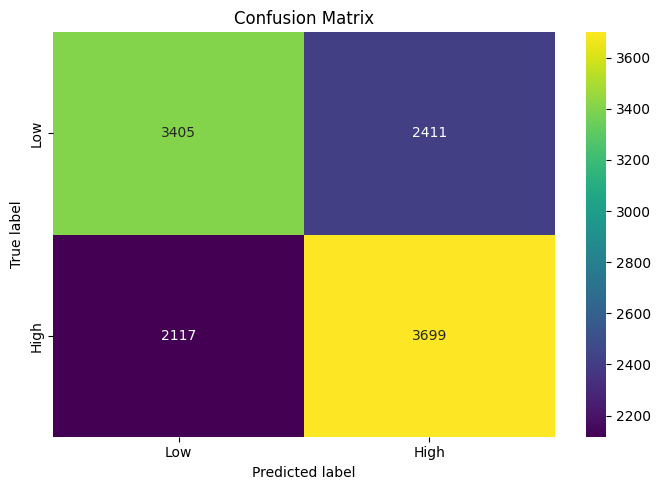

              precision    recall  f1-score   support

         Low       0.62      0.59      0.60      5816
        High       0.61      0.64      0.62      5816

    accuracy                           0.61     11632
   macro avg       0.61      0.61      0.61     11632
weighted avg       0.61      0.61      0.61     11632



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, type_of_model):
    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(X_test)
    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print the classification report
    print(clr)

# Example usage
evaluate_model(bst, X_val, val_data['popularity'], 'LightGBM')

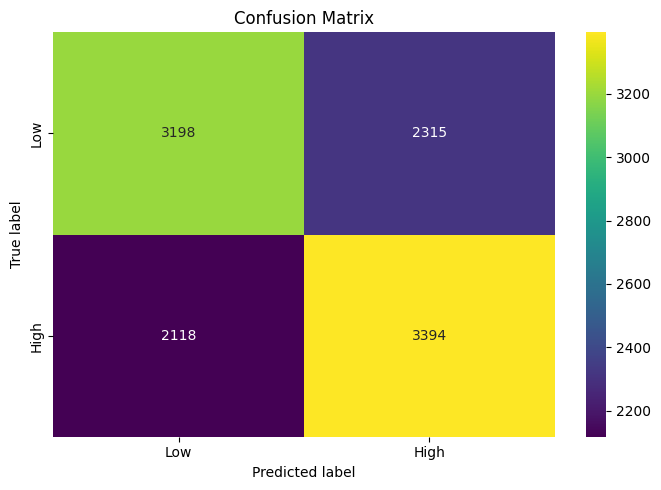

              precision    recall  f1-score   support

         Low       0.60      0.58      0.59      5513
        High       0.59      0.62      0.60      5512

    accuracy                           0.60     11025
   macro avg       0.60      0.60      0.60     11025
weighted avg       0.60      0.60      0.60     11025



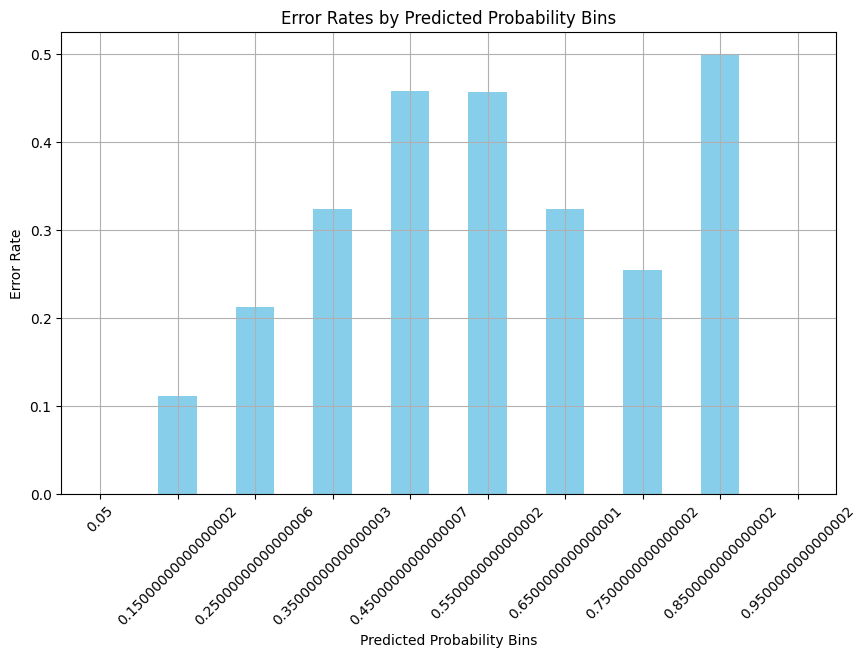

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_and_error_rates(model, X_test, y_test):
    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(X_test)

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

    # Print the classification report
    print(clr)

    # Calculate error rates by probability bins
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred_prob': y_pred_prob
    })

    results['prob_bin'] = pd.cut(results['y_pred_prob'], bins=np.arange(0, 1.1, 0.1), labels=np.arange(0.05, 1.05, 0.1))

    # Calculate error rates
    error_rates = results.groupby('prob_bin').apply(
        lambda x: np.mean(x['y_true'] != (x['y_pred_prob'] > 0.5))
    )

    # Plotting error rates by predicted probability bins
    plt.figure(figsize=(10, 6))
    error_rates.plot(kind='bar', color='skyblue')
    plt.title('Error Rates by Predicted Probability Bins')
    plt.xlabel('Predicted Probability Bins')
    plt.ylabel('Error Rate')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Example usage
evaluate_model_and_error_rates(bst, X_test, test_data['popularity'])